In [1]:
%matplotlib inline

from matplotlib_inline import backend_inline
import numpy as np
import random
import math
import os
import scipy.io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from datetime import datetime
from torch.utils import data
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

backend_inline.set_matplotlib_formats('svg')
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.rcParams['font.sans-serif'] = ['SimHei']

In [2]:
# convert str to datatime
# 将字符串转换为时间
def convert_to_time(hmm):
    year, month, day, hour, minute, second = int(hmm[0]), int(hmm[1]), int(hmm[2]), int(hmm[3]), int(hmm[4]), int(hmm[5])
    return datetime(year=year, month=month, day=day, hour=hour, minute=minute, second=second)


# load .mat data
# 加载.mat格式的数据
def loadMat(matfile):
    data_mat = scipy.io.loadmat(matfile)
    filename = matfile.split("/")[-1].split(".")[0]
    col = data_mat[filename]
    col = col[0][0][0][0]
    size = col.shape[0]

    data_mat = []
    for i in range(size):
        k = list(col[i][3][0].dtype.fields.keys())
        d1, d2 = {}, {}
        if str(col[i][0][0]) != 'impedance':
            for j in range(len(k)):
                t = col[i][3][0][0][j][0];
                l = [t[m] for m in range(len(t))]
                d2[k[j]] = l
        d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2
        data_mat.append(d1)

    return data_mat

# get capacity data
# 得到电池容量的数据
def getBatteryCapacity(Battery):
    cycle, capacity = [], []
    i = 1
    for Bat in Battery:
        if Bat['type'] == 'discharge':
            capacity.append(Bat['data']['Capacity'][0])
            cycle.append(i)
            i += 1
    return [cycle, capacity]

Battery_list = ['B0005', 'B0006', 'B0007', 'B0018']
dir_path = './dataset/'

Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + '.mat ...')
    path = dir_path + name + '.mat'
    data_mat = loadMat(path)
    Battery[name] = getBatteryCapacity(data_mat)

Load Dataset B0005.mat ...


C:\Users\Coyle\AppData\Local\Temp\ipykernel_23940\2811494779.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  d1['type'], d1['temp'], d1['time'], d1['data'] = str(col[i][0][0]), int(col[i][1][0]), str(convert_to_time(col[i][2][0])), d2


Load Dataset B0006.mat ...
Load Dataset B0007.mat ...
Load Dataset B0018.mat ...


In [3]:
len(Battery['B0018'][0]), len(Battery['B0018'][1])

(132, 132)

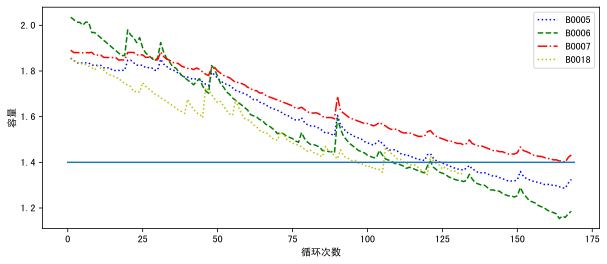

In [4]:
%matplotlib inline

color_list = ['b:', 'g--', 'r-.', 'y:']
# 1.创建画布
plt.figure(figsize=(10, 4), dpi=80)
plt.xlabel('循环次数')
plt.ylabel('容量')

# 2.绘制折线图
for name,color in zip(Battery_list, color_list):
    plt.plot(Battery[name][0], Battery[name][1], color)
    
plt.plot([i for i in range(170)], [1.4] * 170)

# 图例
plt.legend([name for name in Battery_list])

In [5]:
# 构建数据
# 采用 留一评估：一组数据为测试集，其他所有数据全部拿来训练
# train_x 的维度是 window_size ，总样本数为 421
# train_y 的维度是1，总样本数为421
# train_data 是模型预测时的真实数据，用来预测下一时刻的容量，长度为 window_size
# test_data 是 真实的容量数据，用来检验模型的各种参数

def build_seq(text, window_size):
    # text:list of capacity
    x, y = [], []
    for i in range(len(text) - window_size):
        sequence = text[i:i + window_size]
        # target = text[i + window_size] # y 只有一列
        target = text[i + 1:i + 1 + window_size] # y 有 window_size 列
        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)

def get_train_test_data(data_dict, name, window_size=16):
    data_sequence = data_dict[name][1]
    train_data, test_data = data_sequence[:window_size], data_sequence[window_size:]
    
    train_x, train_y = None, None
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_seq(text=v[1], window_size=window_size)
            if train_x is None:
                train_x = data_x
                train_y = data_y
            else:
                train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def load_capacity_data(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [6]:
# 平均绝对误差、均方根误差
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

# 相对误差
# B0005 第125次循环后达到阈值1.4
# B0006 第109次循环后达到阈值1.4
# B0007 数据集中无任何值小于1.4，所以无法达到阈值1.4
# B0018 第97次循环后达到阈值1.4
def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), len(y_predict)
    for i in range(len(y_test) - 1):
        if y_test[i] <= threshold >= y_test[i + 1]:
            true_re = i + 1
            break
    for i in range(len(y_predict) - 1):
        if y_predict[i] <= threshold >= y_predict[i + 1]:
            pred_re = i + 1
            break
    return abs(true_re - pred_re) / true_re

# relative_error(Battery['B0006'][1], Battery['B0006'][1], 1.4)

In [92]:
# 测试 train_iter 的数据是否正确
def validate_train_iter(train_iter):
    for X, Y in train_iter:
        print(X.shape)
        print(Y.shape)
        print(X[1])
        print(Y[1])
        print('Y[:, -1]', Y[:, -1].reshape(-1, 1).shape)
        break

    print(torch.from_numpy(np.array(Battery['B0006'][1][1:18])))

train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[0], window_size=16)
train_x = torch.from_numpy(train_x.astype(np.float32))
train_y = torch.from_numpy(train_y.astype(np.float32))
train_iter = load_capacity_data((train_x, train_y), 30, is_train=False)
validate_train_iter(train_iter)

torch.Size([30, 16])
torch.Size([30, 16])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783])
tensor([2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572, 1.9456,
        1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676])
Y[:, -1] torch.Size([30, 1])
tensor([2.0251, 2.0133, 2.0133, 2.0005, 2.0139, 2.0131, 1.9688, 1.9682, 1.9572,
        1.9456, 1.9348, 1.9233, 1.9119, 1.9011, 1.8892, 1.8783, 1.8676],
       dtype=torch.float64)


In [9]:
# 暂时用不到
# 获取 vocab_size，该值用于nn.Embedding
# 取 vocab_size 为 所有的训练数据集和测试数据集的前 window_size 个数
def get_vocab_size(i, window_size):
    """i 表示当前的留一评估是取的第i个电池为测试数据集"""
    vocab_size = window_size
    for j in range(len(Battery_list)):
        if j != i:
            battery_name = Battery_list[j]
            vocab_size += len(Battery[battery_name][1])
    return vocab_size

In [18]:
# 多头注意力  备份版本
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，
        # num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [7]:
# 多头注意力
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    def forward(self, queries, keys, values):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = nn.functional.softmax(scores, dim=-1)
        return torch.bmm(self.dropout(self.attention_weights), values)

class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values):
        # queries，keys，values的形状: (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        # output的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)


# 测试 多头注意力的 输出
num_hiddens, num_heads = 100, 5
window_size = 16
attention = MultiHeadAttention(window_size, window_size, window_size,
                               num_hiddens, num_heads, 0.5)
print(attention.eval())

batch_size, num_queries = 2, 4
num_kvpairs = 6
X = torch.ones((30, 1, window_size))
Y = torch.ones((30, 1, window_size))
attention(X, Y, Y).shape

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=16, out_features=100, bias=False)
  (W_k): Linear(in_features=16, out_features=100, bias=False)
  (W_v): Linear(in_features=16, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)


torch.Size([30, 1, 100])

In [8]:
# 层规范化
# 假设此时输入的数据维度是[3, 4]，则对3个长度为4的向量求均值方差，得到3个均值和3个方差
# 分别对这3行进行归一化（每一行的4个数字都是均值为0，方差为1） 
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [9]:
# 前馈网络层
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 8])

In [10]:
# 模型 暂时保存不用
class Net(nn.Module):
    def __init__(self, embed_size, window_size, n_class=1, max_len=1000):
        super(Net, self).__init__()
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, window_size, embed_size)) # torch.randn 满足标准正态分布
        

    def forward(self, x): # 输入x 的形状是 (batch_size, window_size)
        X = x.unsqueeze(2) # 输出 X shape: (batch_size, window_size, 1)
        X = self.embedding(X) # 输出 X shape: (batch_size, window_size, embed_size)
        X = X + self.pos_embedding.data # X shape: (batch_size, window_size, embed_size),这里使用的广播机制
        
        
        return X

In [10]:
# 注意力机制块
class AttentionBlock(nn.Module):
    """注意力机制块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads,
                 norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias=False, **kwargs):
        super(AttentionBlock, self).__init__(**kwargs)
        
        # 多头注意力层
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        
        # 层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # 前馈网络层
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        
        # 层规范化
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, Y):
        # attention 的输出 shape: (batch_size, 1, window_size)
        # addnorm1 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm1(X, self.attention(X, Y, Y))
        
        # ffn 的输出 shape: (batch_size, 1, window_size)
        # addnorm2 的输出 shape: (batch_size, 1, window_size)
        X = self.addnorm2(X, self.ffn(X))
        
        return X

In [11]:
# 残差网络
class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        
        Y += X
        return F.relu(Y)

# blk = Residual(3,3)
# X = torch.rand(4, 3, 6, 6)
blk = Residual(1, 8)
X = torch.rand(30, 1, 4, 4)
Y = blk(X)
Y.shape

torch.Size([30, 8, 4, 4])

In [19]:
# 模型
class Net(nn.Module):
    def __init__(self, embed_size, window_size, 
                 key_size, query_size, value_size, num_hiddens, num_heads, dropout,
                 norm_shape, 
                 ffn_num_input, ffn_num_hiddens, 
                 num_layers,
                 input_channels=1, num_channels=8,
                 n_class=1, use_bias=False):
        super(Net, self).__init__()
        
        # 嵌入层来自于nlp，但是不知道是否适用于容量时序数据
        # 嵌入层只使用整型数据，容量数据是浮点型数据，不适用嵌入层
        # self.embedding = nn.Embedding(vocab_size, embed_size) # 嵌入层
        
        # 用线性层扩展维度来代替 nn.Embedding
        # self.embedding = nn.Linear(1, embed_size)
        
        # 位置嵌入是可学习的，因此创建一个足够长的位置嵌入参数，该方法来自于bert
        # bert模型大，训练数据集也够大，所以使用可学习的位置嵌入
        # 锂电池容量数据集不大，不一定适合可学习的位置嵌入
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, window_size)) # torch.randn 满足标准正态分布
        
        # 多头注意力块
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                AttentionBlock(key_size, query_size, value_size, num_hiddens, num_heads,
                             norm_shape, ffn_num_input, ffn_num_hiddens, dropout, use_bias))
        
        # 卷积残差网络层
        self.residual = Residual(input_channels, num_channels)
        
        # 输出层
        self.outLinear = nn.Linear(window_size, n_class)

    def forward(self, X, Y): # 输入 X和Y 的形状都是 (batch_size, window_size)
        X = X.unsqueeze(1) # 输出 X shape: (batch_size, 1, window_size)
        Y = Y.unsqueeze(1) # 输出 Y shape: (batch_size, 1, window_size)
        X = X + self.pos_embedding.data # X shape: (batch_size, 1, window_size),这里使用的广播机制
        
        for i, blk in enumerate(self.blks):
            X = blk(X, Y) # 最终 X shape: (batch_size, 1, window_size)
        
        batch_size, seq_len, feature_size = X.shape
        # X = self.residual(X.reshape(batch_size, seq_len, 4, 4))
        
        X = self.outLinear(X.reshape(batch_size, -1))
        
        return X

In [20]:
# 测试模型的输出
X = torch.zeros((30, 16))
Y = torch.zeros((30, 16))
net = Net(8, 16, 
          16, 16, 16, 16, 4, 0.1, 
          [1, 16], 
          16, 32,
          2)
output = net(X, Y)
output.shape

torch.Size([30, 1])

In [9]:
# 测试模型的输出形状
def validate_model_output_shape(net, X):
    test_y_hat = net(X)
    print(test_y_hat.shape)
    print(test_y_hat[0, 0])

# test_x = torch.ones((1, 1, 16))
# validate_model_output_shape(net, test_x)

In [21]:
def train_epoch(net, train_iter, loss, updater, feature_size, Rated_Capacity): 
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和、训练准确度总和、样本数
    for X, Y in train_iter:
        # 计算梯度并更新参数
        # X = torch.reshape(X / Rated_Capacity, (-1, 1, feature_size)).type(torch.float32)
        X = (X / Rated_Capacity).type(torch.float32)
        # Y = torch.reshape(Y / Rated_Capacity, (-1, 1)).type(torch.float32)
        Y = (Y / Rated_Capacity).type(torch.float32)
        X, Y = X.to(device), Y.to(device)
        
        # y_hat = net(X, Y)
        y_hat = net(X, X)
        l = loss(y_hat, Y[:, -1].reshape(-1, 1))
        
        updater.zero_grad()
        l.backward()
        updater.step()
    
    return l

In [27]:
def train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity):
    net = net.to(device)
  
    mae_epoch_list, rmse_epoch_list, re_epoch_list = [], [], []
    for epoch in range(num_epochs):
        train_loss = train_epoch(net, train_iter, loss, updater, window_size, Rated_Capacity)
        if (epoch + 1) % 100 == 0:
            pre_list = predict(net, train_data, test_data, window_size, Rated_Capacity)
            # print('pre_list', pre_list)
            mae, rmse = evaluation(test_data, pre_list)
            re = relative_error(test_data, pre_list, threshold=Rated_Capacity * 0.7)
            print('epoch:{:<4d} , loss:{:<6.10f} , MAE:{:<6.4f} , RMSE:{:<6.4f} , RE:{:<6.4f}'.format(epoch, train_loss, mae, rmse, re))
            
            if (train_loss < 1e-3) and len(re_epoch_list) > 0 and (re_epoch_list[-1] < re):
                break
            
            mae_epoch_list.append(mae)
            rmse_epoch_list.append(rmse)
            re_epoch_list.append(re)
    return mae_epoch_list[-1], rmse_epoch_list[-1], re_epoch_list[-1]

In [24]:
def predict(net, train_data, test_data, feature_size, Rated_Capacity):
    test_x = train_data.copy()
    point_list = []
    while (len(test_x) - len(train_data)) < len(test_data):
        # x = np.reshape(np.array(test_x[-feature_size:]) / Rated_Capacity, (-1, 1, feature_size)).astype(np.float32)
        x = (np.array(test_x[-feature_size:]) / Rated_Capacity).astype(np.float32)
        x = torch.from_numpy(x).reshape(-1, feature_size).to(device)  # shape: (batch_size, input_size)
        pred = net(x, x).cpu()
        # print('pred.shape', pred.shape)
        next_point = pred.data.numpy()[0, 0] * Rated_Capacity
        # print('next_point', next_point)
        test_x.append(next_point)  # 测试值加入原来序列用来继续预测下一个点
        point_list.append(next_point)  # 保存输出序列最后一个点的预测值
    return point_list

In [29]:
# 电池额定容量
Rated_Capacity = 2.0

# 超参数
batch_size = 30
lr = 0.01
weight_decay = 0.0001
num_epochs = 2000
window_size = 16
embed_size = 8 # 每一个容量数据以8个特征来表示

key_size, query_size, value_size, num_hiddens = 16, 16, 16, 16
num_heads, dropout = 4, 0.5
norm_shape = [1, 16]
ffn_num_input, ffn_num_hiddens = 16, 16
num_layers = 2

# 获取数据集，生成train_iter
# 使用留一评估
mae_s, rmse_s, re_s = [], [], []
for i in range(4):
    train_x, train_y, train_data, test_data = get_train_test_data(Battery, Battery_list[i], window_size=window_size)
    train_x = torch.from_numpy(train_x.astype(np.float32))
    train_y = torch.from_numpy(train_y.astype(np.float32))
    train_iter = load_capacity_data((train_x, train_y), batch_size, is_train=False)
    
    # 拿到 vocab_size
    # vocab_size = get_vocab_size(i, window_size)
    
    # 模型、损失函数、优化器
    net = Net(embed_size, window_size, 
              key_size, query_size, value_size, num_hiddens, 
              num_heads, dropout,
              norm_shape, 
              ffn_num_input, ffn_num_hiddens, 
              num_layers)
    loss = nn.MSELoss()
    updater = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    # 开始训练
    print(f'以电池 { Battery_list[i] } 为测试数据的 数据集 开始训练')
    mae, rmse, re = train(net, train_iter, test_data, batch_size, loss, num_epochs, updater, window_size, Rated_Capacity)
    mae_s.append(mae)
    rmse_s.append(rmse)
    re_s.append(re)

print('---------------------------------')
print('re_s', re_s)
print('---------------------------------')
print(f're mean: {np.array(re_s).mean()}')
print(f'mae mean: {np.array(mae_s).mean()}')
print(f'rmse mean: {np.array(rmse_s).mean()}')
print('---------------------------------')

以电池 B0005 为测试数据的 数据集 开始训练
epoch:99   , loss:0.0086165573 , MAE:0.1668 , RMSE:0.1882 , RE:0.3945
epoch:199  , loss:0.0087552788 , MAE:0.1655 , RMSE:0.1891 , RE:0.3945
epoch:299  , loss:0.0100337695 , MAE:0.1659 , RMSE:0.1882 , RE:0.3945
epoch:399  , loss:0.0093099736 , MAE:0.1611 , RMSE:0.1842 , RE:0.3945
epoch:499  , loss:0.0048603439 , MAE:0.1641 , RMSE:0.1959 , RE:0.1284
epoch:599  , loss:0.0040219575 , MAE:0.1892 , RMSE:0.2354 , RE:0.7431
epoch:699  , loss:0.0043636900 , MAE:0.1606 , RMSE:0.1985 , RE:0.7523
epoch:799  , loss:0.0034155783 , MAE:0.1865 , RMSE:0.2256 , RE:0.7248
epoch:899  , loss:0.0044718445 , MAE:0.1717 , RMSE:0.2039 , RE:0.7064
epoch:999  , loss:0.0027500433 , MAE:0.1658 , RMSE:0.2025 , RE:0.5963
epoch:1099 , loss:0.0036748897 , MAE:0.1663 , RMSE:0.2071 , RE:0.8073
epoch:1199 , loss:0.0032890886 , MAE:0.1979 , RMSE:0.2402 , RE:0.8165
epoch:1299 , loss:0.0065395231 , MAE:0.1648 , RMSE:0.1892 , RE:0.3945
epoch:1399 , loss:0.0039950199 , MAE:0.1632 , RMSE:0.2011 , RE:0